In [29]:
#imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score


#Function created that will load the data
def load_data(pth, names=None, n_data_sets=4):
    if names is None:
        names = ['unit_id', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
        names += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
    dc = {}
    for i in range(n_data_sets):
        p = os.path.join(pth, 'RUL_FD00{}.txt'.format(i+1))
        df_RUL = pd.read_csv(p, sep= ' ', header=None, names=['RUL'], index_col=False)
        p = os.path.join(pth, 'train_FD00{}.txt'.format(i+1))
        df_train = pd.read_csv(p, sep= ' ', header=None, names=names, index_col=False)
        p = os.path.join(pth, 'test_FD00{}.txt'.format(i+1))
        df_test = pd.read_csv(p, sep= ' ', header=None, names=names, index_col=False)
        s = 'FD_00{}'.format(i+1)
        dc[s] = {'df_RUL': df_RUL, 'df_train': df_train, 'df_test': df_test}
    return dc

#Function to drop columns with constant or NaN values
def drop_columns(X):
    cols_nan = X.columns[X.isnull().any()].tolist()
    cols_const = [ col for col in X.columns if len(X[col].unique()) <= 2 ]
    X=X.drop(cols_const+cols_nan,axis=1)
    return X

#Load Data
dirname = os.getcwd()
pth = os.path.join(dirname, 'dataset')
print('loading data...')
dc = load_data(pth)
print('done')


loading data...
done


In [30]:
#Read Training data
df_train = dc['FD_002']['df_train'].copy()
print("Dimension of FD_002_train dataset: ",df_train.shape)
df_train=drop_columns(df_train)
print("New dimension of FD_002_train dataset: ",df_train.shape)
df_train.head()

Dimension of FD_002_train dataset:  (53759, 31)
New dimension of FD_002_train dataset:  (53759, 23)


,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21
0,1,1,34.9983,0.8400,449.44,555.32,1358.61,1137.23,5.48,8.00,...,1.02,42.02,183.06,2387.72,8048.56,9.3461,334,2223,14.73,8.8071
1,1,2,41.9982,0.8408,445.00,549.90,1353.22,1125.78,3.91,5.71,...,1.02,42.20,130.42,2387.66,8072.30,9.3774,330,2212,10.41,6.2665
2,1,3,24.9988,0.6218,462.54,537.31,1256.76,1047.45,7.05,9.02,...,0.94,36.69,164.22,2028.03,7864.87,10.8941,309,1915,14.08,8.6723
3,1,4,42.0077,0.8416,445.00,549.51,1354.03,1126.38,3.91,5.71,...,1.02,41.96,130.72,2387.61,8068.66,9.3528,329,2212,10.59,6.4701
4,1,5,25.0005,0.6203,462.54,537.07,1257.71,1047.93,7.05,9.03,...,0.94,36.89,164.31,2028.00,7861.23,10.8963,309,1915,14.13,8.5286


In [31]:
#Read Test data
df_test = dc['FD_002']['df_test'].copy()
print("Dimension of FD_002_test dataset: ",df_test.shape)
df_test=drop_columns(df_test)
print("New dimension of FD_002_test dataset: ",df_test.shape)
df_test.head()

Dimension of FD_002_test dataset:  (33991, 31)
New dimension of FD_002_test dataset:  (33991, 23)


,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21
0,1,1,9.9987,0.2502,489.05,605.03,1497.17,1304.99,10.52,15.49,...,1.26,45.61,371.69,2388.18,8114.10,8.6476,369,2319,28.42,17.1551
1,1,2,20.0026,0.7000,491.19,607.82,1481.20,1246.11,9.35,13.66,...,1.08,44.26,315.32,2388.12,8053.06,9.2405,364,2324,24.29,14.8039
2,1,3,35.0045,0.8400,449.44,556.00,1359.08,1128.36,5.48,8.00,...,1.02,41.80,183.04,2387.75,8053.04,9.3472,333,2223,14.98,8.9125
3,1,4,42.0066,0.8410,445.00,550.17,1349.69,1127.89,3.91,5.71,...,1.02,42.21,130.40,2387.72,8066.90,9.3961,332,2212,10.35,6.4181
4,1,5,24.9985,0.6213,462.54,536.72,1253.18,1050.69,7.05,9.03,...,0.94,36.76,164.56,2028.05,7865.66,10.8682,305,1915,14.31,8.5740


In [32]:
#Read RUL data
df_RUL = dc['FD_002']['df_RUL'].copy()
df_RUL['unit_id'] = list(range(1, len(df_RUL) + 1))
print("Dimension of FD_002_RUL dataset: ",df_RUL.shape)
df_RUL.head()

Dimension of FD_002_RUL dataset:  (259, 2)


,RUL,unit_id
0,18,1
1,79,2
2,106,3
3,110,4
4,15,5


In [33]:
#Generate column RUL for the train dataset to calculate the Remaining Useful Life or Time to failure
rul=pd.DataFrame(df_train.groupby('unit_id')['time_in_cycles'].max()).reset_index()
rul.columns=['unit_id','max']
df_train=df_train.merge(rul,on=['unit_id'],how='left')
df_train['RUL'] = df_train['max'] - df_train['time_in_cycles']
df_train.head()

,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL
0,1,1,34.9983,0.8400,449.44,555.32,1358.61,1137.23,5.48,8.00,...,183.06,2387.72,8048.56,9.3461,334,2223,14.73,8.8071,149,148
1,1,2,41.9982,0.8408,445.00,549.90,1353.22,1125.78,3.91,5.71,...,130.42,2387.66,8072.30,9.3774,330,2212,10.41,6.2665,149,147
2,1,3,24.9988,0.6218,462.54,537.31,1256.76,1047.45,7.05,9.02,...,164.22,2028.03,7864.87,10.8941,309,1915,14.08,8.6723,149,146
3,1,4,42.0077,0.8416,445.00,549.51,1354.03,1126.38,3.91,5.71,...,130.72,2387.61,8068.66,9.3528,329,2212,10.59,6.4701,149,145
4,1,5,25.0005,0.6203,462.54,537.07,1257.71,1047.93,7.05,9.03,...,164.31,2028.00,7861.23,10.8963,309,1915,14.13,8.5286,149,144


In [34]:
#Train_Data Scaling
scaler=MinMaxScaler()
df_train_scal=df_train.copy()
df_train_scal.iloc[:,2:23] = scaler.fit_transform(df_train_scal.iloc[:,2:23])
df_train_scal.head()

,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL
0,1,1,0.833134,0.997625,0.060269,0.181576,0.311201,0.273095,0.146592,0.144025,...,0.136817,0.992394,0.476508,0.369947,0.322917,0.651163,0.156036,0.159082,149,148
1,1,2,0.999767,0.998575,0.000000,0.131847,0.296600,0.245535,0.000000,0.000000,...,0.003297,0.992229,0.533013,0.381407,0.281250,0.627907,0.007888,0.014562,149,147
2,1,3,0.595096,0.738480,0.238089,0.016332,0.035297,0.056997,0.293184,0.208176,...,0.089030,0.001157,0.039296,0.936731,0.062500,0.000000,0.133745,0.151414,149,146
3,1,4,0.999993,0.999525,0.000000,0.128269,0.298795,0.246979,0.000000,0.000000,...,0.004058,0.992091,0.524349,0.372400,0.270833,0.627907,0.014060,0.026144,149,145
4,1,5,0.595137,0.736698,0.238089,0.014130,0.037871,0.058152,0.293184,0.208805,...,0.089258,0.001075,0.030633,0.937537,0.062500,0.000000,0.135460,0.143240,149,144


In [35]:
#generate RUL_actual column for RUL dataset to show RUL for each unit
rul = pd.DataFrame(df_test.groupby('unit_id')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_id', 'max']
df_RUL['RUL_actual'] = rul['max'] + df_RUL['RUL']
df_RUL.drop('RUL', axis=1, inplace=True)
df_RUL.head()



,unit_id,RUL_actual
0,1,276
1,2,134
2,3,271
3,4,196
4,5,163


In [36]:
#generate RUL column for test data for each instance of a unit_id
df_test=df_test.merge(rul,on=['unit_id'],how='left')
df_test=df_test.merge(df_RUL,on=['unit_id'],how='left')
df_test['RUL'] = df_test['RUL_actual'] - df_test['time_in_cycles']
df_test.head()

,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL_actual,RUL
0,1,1,9.9987,0.2502,489.05,605.03,1497.17,1304.99,10.52,15.49,...,2388.18,8114.10,8.6476,369,2319,28.42,17.1551,258,276,275
1,1,2,20.0026,0.7000,491.19,607.82,1481.20,1246.11,9.35,13.66,...,2388.12,8053.06,9.2405,364,2324,24.29,14.8039,258,276,274
2,1,3,35.0045,0.8400,449.44,556.00,1359.08,1128.36,5.48,8.00,...,2387.75,8053.04,9.3472,333,2223,14.98,8.9125,258,276,273
3,1,4,42.0066,0.8410,445.00,550.17,1349.69,1127.89,3.91,5.71,...,2387.72,8066.90,9.3961,332,2212,10.35,6.4181,258,276,272
4,1,5,24.9985,0.6213,462.54,536.72,1253.18,1050.69,7.05,9.03,...,2028.05,7865.66,10.8682,305,1915,14.31,8.5740,258,276,271


In [37]:
#Test_data Scaling
df_test_scal = df_test.copy()
df_test_scal.iloc[:,2:24] = scaler.fit_transform(df_test_scal.iloc[:,2:24])
df_test_scal.head()

,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL_actual,RUL
0,1,1,0.238019,0.297150,0.597937,0.639243,0.691329,0.680395,0.617180,0.615094,...,0.995085,0.670742,0.117564,0.694737,0.854123,0.625944,0.630724,0.684971,276,275
1,1,2,0.476162,0.831354,0.626985,0.664861,0.647519,0.534663,0.507937,0.500000,...,0.994920,0.514944,0.337173,0.642105,0.864693,0.484214,0.496301,0.684971,276,274
2,1,3,0.833282,0.997625,0.060269,0.189055,0.312512,0.243225,0.146592,0.144025,...,0.993898,0.514893,0.376695,0.315789,0.651163,0.164722,0.159476,0.684971,276,273
3,1,4,0.999967,0.998812,0.000000,0.135525,0.286753,0.242061,0.000000,0.000000,...,0.993815,0.550269,0.394807,0.305263,0.627907,0.005834,0.016866,0.684971,276,272
4,1,5,0.595089,0.737886,0.238089,0.012028,0.022001,0.050986,0.293184,0.208805,...,0.000718,0.036627,0.940070,0.021053,0.000000,0.141730,0.140123,0.684971,276,271


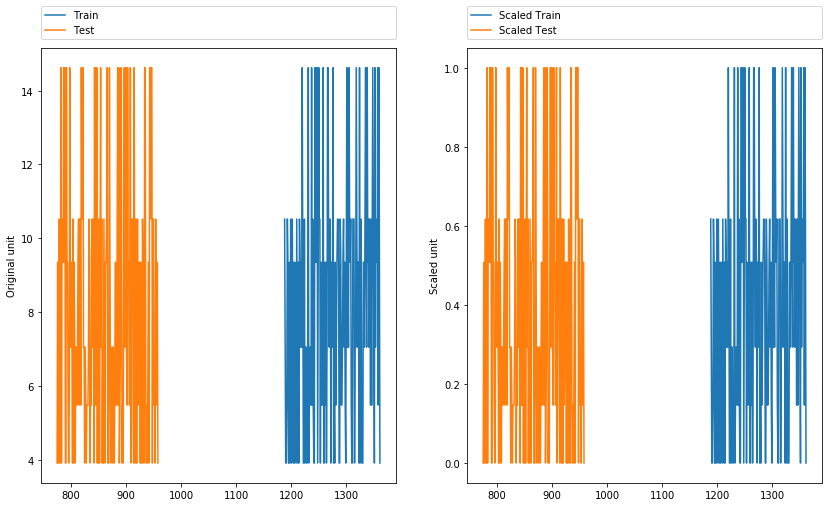

In [38]:
#Visulaize Scaled data
fig = plt.figure(figsize = (14, 8))
fig.add_subplot(1,2,1)
plt.plot(df_train[df_train.unit_id==7].sensor_05)
plt.plot(df_test[df_test.unit_id==7].sensor_05)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(df_train_scal[df_train_scal.unit_id==7].sensor_05)
plt.plot(df_test_scal[df_test_scal.unit_id==7].sensor_05)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

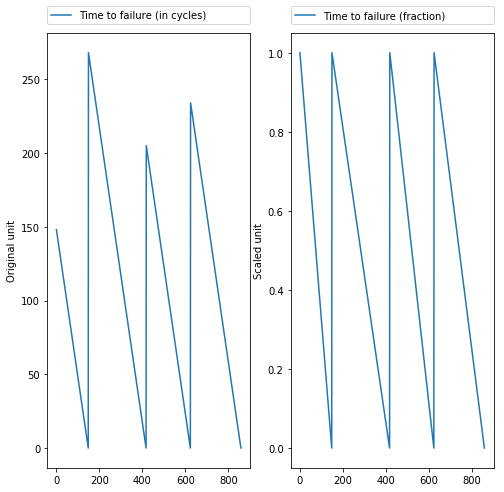

In [39]:
#Time To Failure/ Remaining Useful life in Fraction
def TTF_Fraction(data,x):
    return(data.RUL[x]-data.RUL.min()) / float(data.RUL.max()-data.RUL.min())

frac_TTFs = []
frac_TTF = []

for i in range(df_train['unit_id'].min(),df_train['unit_id'].max()+1):
    data=df_train[df_train.unit_id==i]
    data = data.reset_index(drop=True)
    for j in range(len(data)):
        frac_TTFs = TTF_Fraction(data, j)
        frac_TTF.append(frac_TTFs)
df_train_scal['frac_TTF'] = frac_TTF

max_cycles_train = df_train.groupby('unit_id', as_index=False)['time_in_cycles'].max()
max_cycles_test = df_test.groupby('unit_id', as_index=False)['time_in_cycles'].max()
    
mx = max_cycles_train.iloc[0:4,1].sum()

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(df_train.RUL[0:mx])
plt.legend(['Time to failure (in cycles)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(df_train_scal.frac_TTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [40]:
#show dataframe to get the column numbers of dataset to be used during training and testing of the system
pd.DataFrame(df_train_scal.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL,frac_TTF


In [41]:
pd.DataFrame(df_test_scal.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL_actual,RUL


In [42]:
#Build Model
X_train = df_train_scal.values[:,1:23]
Y_train = df_train_scal.values[:, 25]
X_test = df_test_scal.values[:,1:23]
Y_test=df_test_scal.values[:,25]

model = Sequential()
#train_op = tf.train.GradientDescentOptimizer(0.01)
model.add(Dense(50, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(output_dim=1,activation='sigmoid'))
model.compile(loss='mse', optimizer=optimizers.SGD(lr=0.001), metrics=['mae','accuracy'])
graph_plot=model.fit(X_train, Y_train, nb_epoch=2000,batch_size=900,validation_split=0.2,shuffle=True, verbose=2)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoid")`
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 43007 samples, validate on 10752 samples
Epoch 1/2000
0s - loss: 0.0855 - mean_absolute_error: 0.2462 - acc: 0.0048 - val_loss: 0.0632 - val_mean_absolute_error: 0.2107 - val_acc: 0.0049
Epoch 2/2000
0s - loss: 0.0632 - mean_absolute_error: 0.2110 - acc: 0.0048 - val_loss: 0.0626 - val_mean_absolute_error: 0.2101 - val_acc: 0.0049
Epoch 3/2000
0s - loss: 0.0626 - mean_absolute_error: 0.2101 - acc: 0.0048 - val_loss: 0.0621 - val_mean_absolute_error: 0.2094 - val_acc: 0.0049
Epoch 4/2000
0s - loss: 0.0621 - mean_absolute_error: 0.2093 - acc: 0.0048 - val_loss: 0.0616 - val_mean_absolute_error: 0.2081 - val_acc: 0.0049
Epoch 5/2000
0s - loss: 0.0617 - mean_absolute_error: 0.2085 - acc: 0.0048 - val_loss: 0.0611 - val_mean_absolute_error: 0.2076 - val_acc: 0.0049
Epoch 6/2000
0s - loss: 0.0612 - mean_absolute_error: 0.2077 - acc: 0.0049 - val_loss: 0.0607 - val_mean_absolute_error: 0.2068 - val_acc: 0.0057
Epoch 7/2000
0s - loss: 0.0608 - mean_absolute_error: 0.2070 - acc: 0.0053

0s - loss: 0.0481 - mean_absolute_error: 0.1828 - acc: 0.0096 - val_loss: 0.0479 - val_mean_absolute_error: 0.1823 - val_acc: 0.0098
Epoch 58/2000
0s - loss: 0.0480 - mean_absolute_error: 0.1825 - acc: 0.0096 - val_loss: 0.0478 - val_mean_absolute_error: 0.1820 - val_acc: 0.0098
Epoch 59/2000
0s - loss: 0.0478 - mean_absolute_error: 0.1821 - acc: 0.0096 - val_loss: 0.0476 - val_mean_absolute_error: 0.1817 - val_acc: 0.0098
Epoch 60/2000
0s - loss: 0.0476 - mean_absolute_error: 0.1818 - acc: 0.0096 - val_loss: 0.0474 - val_mean_absolute_error: 0.1812 - val_acc: 0.0098
Epoch 61/2000
0s - loss: 0.0474 - mean_absolute_error: 0.1814 - acc: 0.0096 - val_loss: 0.0472 - val_mean_absolute_error: 0.1810 - val_acc: 0.0098
Epoch 62/2000
0s - loss: 0.0472 - mean_absolute_error: 0.1810 - acc: 0.0096 - val_loss: 0.0471 - val_mean_absolute_error: 0.1805 - val_acc: 0.0098
Epoch 63/2000
0s - loss: 0.0471 - mean_absolute_error: 0.1807 - acc: 0.0096 - val_loss: 0.0469 - val_mean_absolute_error: 0.1804 - v

0s - loss: 0.0397 - mean_absolute_error: 0.1651 - acc: 0.0096 - val_loss: 0.0397 - val_mean_absolute_error: 0.1652 - val_acc: 0.0098
Epoch 114/2000
0s - loss: 0.0396 - mean_absolute_error: 0.1648 - acc: 0.0096 - val_loss: 0.0396 - val_mean_absolute_error: 0.1650 - val_acc: 0.0098
Epoch 115/2000
0s - loss: 0.0395 - mean_absolute_error: 0.1646 - acc: 0.0096 - val_loss: 0.0395 - val_mean_absolute_error: 0.1647 - val_acc: 0.0098
Epoch 116/2000
0s - loss: 0.0393 - mean_absolute_error: 0.1643 - acc: 0.0096 - val_loss: 0.0393 - val_mean_absolute_error: 0.1644 - val_acc: 0.0098
Epoch 117/2000
0s - loss: 0.0392 - mean_absolute_error: 0.1640 - acc: 0.0096 - val_loss: 0.0392 - val_mean_absolute_error: 0.1641 - val_acc: 0.0098
Epoch 118/2000
0s - loss: 0.0391 - mean_absolute_error: 0.1638 - acc: 0.0096 - val_loss: 0.0391 - val_mean_absolute_error: 0.1639 - val_acc: 0.0098
Epoch 119/2000
0s - loss: 0.0390 - mean_absolute_error: 0.1635 - acc: 0.0096 - val_loss: 0.0390 - val_mean_absolute_error: 0.16

0s - loss: 0.0337 - mean_absolute_error: 0.1515 - acc: 0.0096 - val_loss: 0.0339 - val_mean_absolute_error: 0.1522 - val_acc: 0.0098
Epoch 170/2000
0s - loss: 0.0336 - mean_absolute_error: 0.1513 - acc: 0.0096 - val_loss: 0.0338 - val_mean_absolute_error: 0.1521 - val_acc: 0.0098
Epoch 171/2000
0s - loss: 0.0335 - mean_absolute_error: 0.1511 - acc: 0.0096 - val_loss: 0.0337 - val_mean_absolute_error: 0.1517 - val_acc: 0.0098
Epoch 172/2000
0s - loss: 0.0334 - mean_absolute_error: 0.1509 - acc: 0.0096 - val_loss: 0.0336 - val_mean_absolute_error: 0.1516 - val_acc: 0.0098
Epoch 173/2000
0s - loss: 0.0333 - mean_absolute_error: 0.1507 - acc: 0.0096 - val_loss: 0.0335 - val_mean_absolute_error: 0.1514 - val_acc: 0.0098
Epoch 174/2000
0s - loss: 0.0332 - mean_absolute_error: 0.1505 - acc: 0.0096 - val_loss: 0.0335 - val_mean_absolute_error: 0.1511 - val_acc: 0.0098
Epoch 175/2000
0s - loss: 0.0332 - mean_absolute_error: 0.1503 - acc: 0.0096 - val_loss: 0.0334 - val_mean_absolute_error: 0.15

0s - loss: 0.0293 - mean_absolute_error: 0.1408 - acc: 0.0096 - val_loss: 0.0297 - val_mean_absolute_error: 0.1421 - val_acc: 0.0098
Epoch 226/2000
0s - loss: 0.0292 - mean_absolute_error: 0.1407 - acc: 0.0096 - val_loss: 0.0296 - val_mean_absolute_error: 0.1420 - val_acc: 0.0098
Epoch 227/2000
0s - loss: 0.0292 - mean_absolute_error: 0.1405 - acc: 0.0096 - val_loss: 0.0295 - val_mean_absolute_error: 0.1418 - val_acc: 0.0098
Epoch 228/2000
0s - loss: 0.0291 - mean_absolute_error: 0.1404 - acc: 0.0096 - val_loss: 0.0295 - val_mean_absolute_error: 0.1416 - val_acc: 0.0098
Epoch 229/2000
0s - loss: 0.0291 - mean_absolute_error: 0.1402 - acc: 0.0096 - val_loss: 0.0294 - val_mean_absolute_error: 0.1415 - val_acc: 0.0098
Epoch 230/2000
0s - loss: 0.0290 - mean_absolute_error: 0.1400 - acc: 0.0096 - val_loss: 0.0293 - val_mean_absolute_error: 0.1413 - val_acc: 0.0098
Epoch 231/2000
0s - loss: 0.0289 - mean_absolute_error: 0.1398 - acc: 0.0096 - val_loss: 0.0293 - val_mean_absolute_error: 0.14

0s - loss: 0.0260 - mean_absolute_error: 0.1324 - acc: 0.0096 - val_loss: 0.0265 - val_mean_absolute_error: 0.1343 - val_acc: 0.0098
Epoch 282/2000
0s - loss: 0.0260 - mean_absolute_error: 0.1322 - acc: 0.0096 - val_loss: 0.0265 - val_mean_absolute_error: 0.1342 - val_acc: 0.0098
Epoch 283/2000
0s - loss: 0.0259 - mean_absolute_error: 0.1321 - acc: 0.0096 - val_loss: 0.0264 - val_mean_absolute_error: 0.1341 - val_acc: 0.0098
Epoch 284/2000
0s - loss: 0.0259 - mean_absolute_error: 0.1320 - acc: 0.0096 - val_loss: 0.0264 - val_mean_absolute_error: 0.1340 - val_acc: 0.0098
Epoch 285/2000
0s - loss: 0.0258 - mean_absolute_error: 0.1318 - acc: 0.0096 - val_loss: 0.0263 - val_mean_absolute_error: 0.1338 - val_acc: 0.0098
Epoch 286/2000
0s - loss: 0.0258 - mean_absolute_error: 0.1317 - acc: 0.0096 - val_loss: 0.0263 - val_mean_absolute_error: 0.1337 - val_acc: 0.0098
Epoch 287/2000
0s - loss: 0.0257 - mean_absolute_error: 0.1316 - acc: 0.0096 - val_loss: 0.0263 - val_mean_absolute_error: 0.13

0s - loss: 0.0235 - mean_absolute_error: 0.1255 - acc: 0.0096 - val_loss: 0.0241 - val_mean_absolute_error: 0.1282 - val_acc: 0.0098
Epoch 338/2000
0s - loss: 0.0235 - mean_absolute_error: 0.1255 - acc: 0.0096 - val_loss: 0.0241 - val_mean_absolute_error: 0.1281 - val_acc: 0.0098
Epoch 339/2000
0s - loss: 0.0235 - mean_absolute_error: 0.1253 - acc: 0.0096 - val_loss: 0.0241 - val_mean_absolute_error: 0.1279 - val_acc: 0.0098
Epoch 340/2000
0s - loss: 0.0234 - mean_absolute_error: 0.1252 - acc: 0.0096 - val_loss: 0.0240 - val_mean_absolute_error: 0.1278 - val_acc: 0.0098
Epoch 341/2000
0s - loss: 0.0234 - mean_absolute_error: 0.1251 - acc: 0.0096 - val_loss: 0.0240 - val_mean_absolute_error: 0.1277 - val_acc: 0.0098
Epoch 342/2000
0s - loss: 0.0234 - mean_absolute_error: 0.1250 - acc: 0.0096 - val_loss: 0.0240 - val_mean_absolute_error: 0.1276 - val_acc: 0.0098
Epoch 343/2000
0s - loss: 0.0233 - mean_absolute_error: 0.1249 - acc: 0.0096 - val_loss: 0.0239 - val_mean_absolute_error: 0.12

0s - loss: 0.0216 - mean_absolute_error: 0.1200 - acc: 0.0096 - val_loss: 0.0223 - val_mean_absolute_error: 0.1232 - val_acc: 0.0098
Epoch 394/2000
0s - loss: 0.0216 - mean_absolute_error: 0.1199 - acc: 0.0096 - val_loss: 0.0223 - val_mean_absolute_error: 0.1231 - val_acc: 0.0098
Epoch 395/2000
0s - loss: 0.0215 - mean_absolute_error: 0.1198 - acc: 0.0096 - val_loss: 0.0223 - val_mean_absolute_error: 0.1230 - val_acc: 0.0098
Epoch 396/2000
0s - loss: 0.0215 - mean_absolute_error: 0.1198 - acc: 0.0096 - val_loss: 0.0222 - val_mean_absolute_error: 0.1229 - val_acc: 0.0098
Epoch 397/2000
0s - loss: 0.0215 - mean_absolute_error: 0.1197 - acc: 0.0096 - val_loss: 0.0222 - val_mean_absolute_error: 0.1229 - val_acc: 0.0098
Epoch 398/2000
0s - loss: 0.0215 - mean_absolute_error: 0.1196 - acc: 0.0096 - val_loss: 0.0222 - val_mean_absolute_error: 0.1228 - val_acc: 0.0098
Epoch 399/2000
0s - loss: 0.0214 - mean_absolute_error: 0.1195 - acc: 0.0096 - val_loss: 0.0222 - val_mean_absolute_error: 0.12

0s - loss: 0.0201 - mean_absolute_error: 0.1155 - acc: 0.0096 - val_loss: 0.0209 - val_mean_absolute_error: 0.1191 - val_acc: 0.0098
Epoch 450/2000
0s - loss: 0.0201 - mean_absolute_error: 0.1154 - acc: 0.0096 - val_loss: 0.0208 - val_mean_absolute_error: 0.1191 - val_acc: 0.0098
Epoch 451/2000
0s - loss: 0.0200 - mean_absolute_error: 0.1153 - acc: 0.0096 - val_loss: 0.0208 - val_mean_absolute_error: 0.1190 - val_acc: 0.0098
Epoch 452/2000
0s - loss: 0.0200 - mean_absolute_error: 0.1153 - acc: 0.0096 - val_loss: 0.0208 - val_mean_absolute_error: 0.1189 - val_acc: 0.0098
Epoch 453/2000
0s - loss: 0.0200 - mean_absolute_error: 0.1152 - acc: 0.0096 - val_loss: 0.0208 - val_mean_absolute_error: 0.1189 - val_acc: 0.0098
Epoch 454/2000
0s - loss: 0.0200 - mean_absolute_error: 0.1151 - acc: 0.0096 - val_loss: 0.0207 - val_mean_absolute_error: 0.1188 - val_acc: 0.0098
Epoch 455/2000
0s - loss: 0.0199 - mean_absolute_error: 0.1150 - acc: 0.0096 - val_loss: 0.0207 - val_mean_absolute_error: 0.11

0s - loss: 0.0189 - mean_absolute_error: 0.1117 - acc: 0.0096 - val_loss: 0.0197 - val_mean_absolute_error: 0.1158 - val_acc: 0.0098
Epoch 506/2000
0s - loss: 0.0189 - mean_absolute_error: 0.1117 - acc: 0.0096 - val_loss: 0.0197 - val_mean_absolute_error: 0.1157 - val_acc: 0.0098
Epoch 507/2000
0s - loss: 0.0188 - mean_absolute_error: 0.1116 - acc: 0.0096 - val_loss: 0.0197 - val_mean_absolute_error: 0.1157 - val_acc: 0.0098
Epoch 508/2000
0s - loss: 0.0188 - mean_absolute_error: 0.1115 - acc: 0.0096 - val_loss: 0.0197 - val_mean_absolute_error: 0.1156 - val_acc: 0.0098
Epoch 509/2000
0s - loss: 0.0188 - mean_absolute_error: 0.1115 - acc: 0.0096 - val_loss: 0.0197 - val_mean_absolute_error: 0.1156 - val_acc: 0.0098
Epoch 510/2000
0s - loss: 0.0188 - mean_absolute_error: 0.1114 - acc: 0.0096 - val_loss: 0.0196 - val_mean_absolute_error: 0.1155 - val_acc: 0.0098
Epoch 511/2000
0s - loss: 0.0188 - mean_absolute_error: 0.1113 - acc: 0.0096 - val_loss: 0.0196 - val_mean_absolute_error: 0.11

0s - loss: 0.0179 - mean_absolute_error: 0.1086 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.1130 - val_acc: 0.0098
Epoch 562/2000
0s - loss: 0.0179 - mean_absolute_error: 0.1085 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.1129 - val_acc: 0.0098
Epoch 563/2000
0s - loss: 0.0179 - mean_absolute_error: 0.1085 - acc: 0.0096 - val_loss: 0.0188 - val_mean_absolute_error: 0.1129 - val_acc: 0.0098
Epoch 564/2000
0s - loss: 0.0178 - mean_absolute_error: 0.1084 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.1128 - val_acc: 0.0098
Epoch 565/2000
0s - loss: 0.0178 - mean_absolute_error: 0.1083 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.1128 - val_acc: 0.0098
Epoch 566/2000
0s - loss: 0.0178 - mean_absolute_error: 0.1083 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.1127 - val_acc: 0.0098
Epoch 567/2000
0s - loss: 0.0178 - mean_absolute_error: 0.1082 - acc: 0.0096 - val_loss: 0.0187 - val_mean_absolute_error: 0.11

0s - loss: 0.0171 - mean_absolute_error: 0.1059 - acc: 0.0096 - val_loss: 0.0180 - val_mean_absolute_error: 0.1106 - val_acc: 0.0098
Epoch 618/2000
0s - loss: 0.0171 - mean_absolute_error: 0.1059 - acc: 0.0096 - val_loss: 0.0181 - val_mean_absolute_error: 0.1107 - val_acc: 0.0098
Epoch 619/2000
0s - loss: 0.0171 - mean_absolute_error: 0.1058 - acc: 0.0096 - val_loss: 0.0180 - val_mean_absolute_error: 0.1105 - val_acc: 0.0098
Epoch 620/2000
0s - loss: 0.0171 - mean_absolute_error: 0.1058 - acc: 0.0096 - val_loss: 0.0180 - val_mean_absolute_error: 0.1105 - val_acc: 0.0098
Epoch 621/2000
0s - loss: 0.0170 - mean_absolute_error: 0.1057 - acc: 0.0096 - val_loss: 0.0179 - val_mean_absolute_error: 0.1104 - val_acc: 0.0098
Epoch 622/2000
0s - loss: 0.0170 - mean_absolute_error: 0.1057 - acc: 0.0096 - val_loss: 0.0180 - val_mean_absolute_error: 0.1105 - val_acc: 0.0098
Epoch 623/2000
0s - loss: 0.0170 - mean_absolute_error: 0.1057 - acc: 0.0096 - val_loss: 0.0179 - val_mean_absolute_error: 0.11

0s - loss: 0.0164 - mean_absolute_error: 0.1037 - acc: 0.0096 - val_loss: 0.0174 - val_mean_absolute_error: 0.1085 - val_acc: 0.0098
Epoch 674/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1036 - acc: 0.0096 - val_loss: 0.0173 - val_mean_absolute_error: 0.1085 - val_acc: 0.0098
Epoch 675/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1036 - acc: 0.0096 - val_loss: 0.0174 - val_mean_absolute_error: 0.1085 - val_acc: 0.0098
Epoch 676/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1036 - acc: 0.0096 - val_loss: 0.0173 - val_mean_absolute_error: 0.1084 - val_acc: 0.0098
Epoch 677/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1035 - acc: 0.0096 - val_loss: 0.0173 - val_mean_absolute_error: 0.1084 - val_acc: 0.0098
Epoch 678/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1035 - acc: 0.0096 - val_loss: 0.0173 - val_mean_absolute_error: 0.1083 - val_acc: 0.0098
Epoch 679/2000
0s - loss: 0.0164 - mean_absolute_error: 0.1035 - acc: 0.0096 - val_loss: 0.0174 - val_mean_absolute_error: 0.10

0s - loss: 0.0159 - mean_absolute_error: 0.1017 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.1068 - val_acc: 0.0098
Epoch 730/2000
0s - loss: 0.0159 - mean_absolute_error: 0.1017 - acc: 0.0096 - val_loss: 0.0169 - val_mean_absolute_error: 0.1068 - val_acc: 0.0098
Epoch 731/2000
0s - loss: 0.0158 - mean_absolute_error: 0.1016 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.1067 - val_acc: 0.0098
Epoch 732/2000
0s - loss: 0.0158 - mean_absolute_error: 0.1016 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.1067 - val_acc: 0.0098
Epoch 733/2000
0s - loss: 0.0158 - mean_absolute_error: 0.1016 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.1067 - val_acc: 0.0098
Epoch 734/2000
0s - loss: 0.0158 - mean_absolute_error: 0.1016 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.1066 - val_acc: 0.0098
Epoch 735/2000
0s - loss: 0.0158 - mean_absolute_error: 0.1015 - acc: 0.0096 - val_loss: 0.0168 - val_mean_absolute_error: 0.10

0s - loss: 0.0154 - mean_absolute_error: 0.1000 - acc: 0.0096 - val_loss: 0.0164 - val_mean_absolute_error: 0.1052 - val_acc: 0.0098
Epoch 786/2000
0s - loss: 0.0154 - mean_absolute_error: 0.1000 - acc: 0.0096 - val_loss: 0.0164 - val_mean_absolute_error: 0.1052 - val_acc: 0.0098
Epoch 787/2000
0s - loss: 0.0154 - mean_absolute_error: 0.1000 - acc: 0.0096 - val_loss: 0.0163 - val_mean_absolute_error: 0.1052 - val_acc: 0.0098
Epoch 788/2000
0s - loss: 0.0154 - mean_absolute_error: 0.0999 - acc: 0.0096 - val_loss: 0.0164 - val_mean_absolute_error: 0.1052 - val_acc: 0.0098
Epoch 789/2000
0s - loss: 0.0154 - mean_absolute_error: 0.0999 - acc: 0.0096 - val_loss: 0.0163 - val_mean_absolute_error: 0.1051 - val_acc: 0.0098
Epoch 790/2000
0s - loss: 0.0153 - mean_absolute_error: 0.0999 - acc: 0.0096 - val_loss: 0.0164 - val_mean_absolute_error: 0.1052 - val_acc: 0.0098
Epoch 791/2000
0s - loss: 0.0153 - mean_absolute_error: 0.0998 - acc: 0.0096 - val_loss: 0.0163 - val_mean_absolute_error: 0.10

0s - loss: 0.0150 - mean_absolute_error: 0.0985 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1039 - val_acc: 0.0098
Epoch 842/2000
0s - loss: 0.0150 - mean_absolute_error: 0.0985 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1040 - val_acc: 0.0098
Epoch 843/2000
0s - loss: 0.0150 - mean_absolute_error: 0.0985 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1039 - val_acc: 0.0098
Epoch 844/2000
0s - loss: 0.0150 - mean_absolute_error: 0.0985 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1039 - val_acc: 0.0098
Epoch 845/2000
0s - loss: 0.0149 - mean_absolute_error: 0.0984 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1038 - val_acc: 0.0098
Epoch 846/2000
0s - loss: 0.0149 - mean_absolute_error: 0.0984 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.1038 - val_acc: 0.0098
Epoch 847/2000
0s - loss: 0.0149 - mean_absolute_error: 0.0984 - acc: 0.0096 - val_loss: 0.0160 - val_mean_absolute_error: 0.10

0s - loss: 0.0146 - mean_absolute_error: 0.0972 - acc: 0.0096 - val_loss: 0.0156 - val_mean_absolute_error: 0.1027 - val_acc: 0.0098
Epoch 898/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0972 - acc: 0.0096 - val_loss: 0.0156 - val_mean_absolute_error: 0.1027 - val_acc: 0.0098
Epoch 899/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0972 - acc: 0.0096 - val_loss: 0.0156 - val_mean_absolute_error: 0.1027 - val_acc: 0.0098
Epoch 900/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0972 - acc: 0.0096 - val_loss: 0.0157 - val_mean_absolute_error: 0.1028 - val_acc: 0.0098
Epoch 901/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0972 - acc: 0.0096 - val_loss: 0.0156 - val_mean_absolute_error: 0.1027 - val_acc: 0.0098
Epoch 902/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0971 - acc: 0.0096 - val_loss: 0.0157 - val_mean_absolute_error: 0.1027 - val_acc: 0.0098
Epoch 903/2000
0s - loss: 0.0146 - mean_absolute_error: 0.0971 - acc: 0.0096 - val_loss: 0.0157 - val_mean_absolute_error: 0.10

0s - loss: 0.0143 - mean_absolute_error: 0.0961 - acc: 0.0096 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016 - val_acc: 0.0098
Epoch 954/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0960 - acc: 0.0096 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016 - val_acc: 0.0098
Epoch 955/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0961 - acc: 0.0096 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016 - val_acc: 0.0098
Epoch 956/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0960 - acc: 0.0096 - val_loss: 0.0154 - val_mean_absolute_error: 0.1017 - val_acc: 0.0098
Epoch 957/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0960 - acc: 0.0096 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016 - val_acc: 0.0098
Epoch 958/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0960 - acc: 0.0096 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016 - val_acc: 0.0098
Epoch 959/2000
0s - loss: 0.0143 - mean_absolute_error: 0.0960 - acc: 0.0096 - val_loss: 0.0154 - val_mean_absolute_error: 0.10

0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1008 - val_acc: 0.0098
Epoch 1010/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1006 - val_acc: 0.0098
Epoch 1011/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1006 - val_acc: 0.0098
Epoch 1012/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1007 - val_acc: 0.0098
Epoch 1013/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1007 - val_acc: 0.0098
Epoch 1014/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0950 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error: 0.1006 - val_acc: 0.0098
Epoch 1015/2000
0s - loss: 0.0140 - mean_absolute_error: 0.0949 - acc: 0.0096 - val_loss: 0.0151 - val_mean_absolute_error

0s - loss: 0.0138 - mean_absolute_error: 0.0941 - acc: 0.0096 - val_loss: 0.0148 - val_mean_absolute_error: 0.0998 - val_acc: 0.0098
Epoch 1065/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0941 - acc: 0.0096 - val_loss: 0.0149 - val_mean_absolute_error: 0.0998 - val_acc: 0.0098
Epoch 1066/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0941 - acc: 0.0096 - val_loss: 0.0149 - val_mean_absolute_error: 0.0998 - val_acc: 0.0098
Epoch 1067/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0941 - acc: 0.0096 - val_loss: 0.0148 - val_mean_absolute_error: 0.0997 - val_acc: 0.0098
Epoch 1068/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0940 - acc: 0.0096 - val_loss: 0.0149 - val_mean_absolute_error: 0.0998 - val_acc: 0.0098
Epoch 1069/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0940 - acc: 0.0096 - val_loss: 0.0149 - val_mean_absolute_error: 0.0998 - val_acc: 0.0098
Epoch 1070/2000
0s - loss: 0.0138 - mean_absolute_error: 0.0940 - acc: 0.0096 - val_loss: 0.0148 - val_mean_absolute_error

0s - loss: 0.0136 - mean_absolute_error: 0.0933 - acc: 0.0096 - val_loss: 0.0146 - val_mean_absolute_error: 0.0990 - val_acc: 0.0098
Epoch 1120/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0146 - val_mean_absolute_error: 0.0990 - val_acc: 0.0098
Epoch 1121/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0146 - val_mean_absolute_error: 0.0990 - val_acc: 0.0098
Epoch 1122/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0147 - val_mean_absolute_error: 0.0991 - val_acc: 0.0098
Epoch 1123/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0147 - val_mean_absolute_error: 0.0991 - val_acc: 0.0098
Epoch 1124/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0146 - val_mean_absolute_error: 0.0990 - val_acc: 0.0098
Epoch 1125/2000
0s - loss: 0.0136 - mean_absolute_error: 0.0932 - acc: 0.0096 - val_loss: 0.0146 - val_mean_absolute_error

0s - loss: 0.0134 - mean_absolute_error: 0.0925 - acc: 0.0096 - val_loss: 0.0145 - val_mean_absolute_error: 0.0983 - val_acc: 0.0098
Epoch 1175/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0925 - acc: 0.0096 - val_loss: 0.0145 - val_mean_absolute_error: 0.0983 - val_acc: 0.0098
Epoch 1176/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0925 - acc: 0.0096 - val_loss: 0.0144 - val_mean_absolute_error: 0.0983 - val_acc: 0.0098
Epoch 1177/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0924 - acc: 0.0096 - val_loss: 0.0145 - val_mean_absolute_error: 0.0983 - val_acc: 0.0098
Epoch 1178/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0924 - acc: 0.0096 - val_loss: 0.0144 - val_mean_absolute_error: 0.0982 - val_acc: 0.0098
Epoch 1179/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0924 - acc: 0.0096 - val_loss: 0.0144 - val_mean_absolute_error: 0.0982 - val_acc: 0.0098
Epoch 1180/2000
0s - loss: 0.0134 - mean_absolute_error: 0.0924 - acc: 0.0096 - val_loss: 0.0145 - val_mean_absolute_error

0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0977 - val_acc: 0.0098
Epoch 1230/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0918 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0977 - val_acc: 0.0098
Epoch 1231/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0976 - val_acc: 0.0098
Epoch 1232/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0976 - val_acc: 0.0098
Epoch 1233/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0976 - val_acc: 0.0098
Epoch 1234/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error: 0.0977 - val_acc: 0.0098
Epoch 1235/2000
0s - loss: 0.0132 - mean_absolute_error: 0.0917 - acc: 0.0096 - val_loss: 0.0143 - val_mean_absolute_error

0s - loss: 0.0131 - mean_absolute_error: 0.0911 - acc: 0.0096 - val_loss: 0.0142 - val_mean_absolute_error: 0.0971 - val_acc: 0.0098
Epoch 1285/2000
0s - loss: 0.0131 - mean_absolute_error: 0.0911 - acc: 0.0096 - val_loss: 0.0141 - val_mean_absolute_error: 0.0970 - val_acc: 0.0098
Epoch 1286/2000
0s - loss: 0.0130 - mean_absolute_error: 0.0910 - acc: 0.0096 - val_loss: 0.0142 - val_mean_absolute_error: 0.0972 - val_acc: 0.0098
Epoch 1287/2000
0s - loss: 0.0130 - mean_absolute_error: 0.0911 - acc: 0.0096 - val_loss: 0.0141 - val_mean_absolute_error: 0.0970 - val_acc: 0.0098
Epoch 1288/2000
0s - loss: 0.0130 - mean_absolute_error: 0.0911 - acc: 0.0096 - val_loss: 0.0141 - val_mean_absolute_error: 0.0970 - val_acc: 0.0098
Epoch 1289/2000
0s - loss: 0.0130 - mean_absolute_error: 0.0910 - acc: 0.0096 - val_loss: 0.0141 - val_mean_absolute_error: 0.0970 - val_acc: 0.0098
Epoch 1290/2000
0s - loss: 0.0130 - mean_absolute_error: 0.0910 - acc: 0.0096 - val_loss: 0.0141 - val_mean_absolute_error

0s - loss: 0.0129 - mean_absolute_error: 0.0905 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1340/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0905 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1341/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0905 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1342/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0904 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1343/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0905 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1344/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0904 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error: 0.0965 - val_acc: 0.0098
Epoch 1345/2000
0s - loss: 0.0129 - mean_absolute_error: 0.0904 - acc: 0.0096 - val_loss: 0.0140 - val_mean_absolute_error

0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0960 - val_acc: 0.0098
Epoch 1395/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0959 - val_acc: 0.0098
Epoch 1396/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0960 - val_acc: 0.0098
Epoch 1397/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0960 - val_acc: 0.0098
Epoch 1398/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0959 - val_acc: 0.0098
Epoch 1399/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error: 0.0959 - val_acc: 0.0098
Epoch 1400/2000
0s - loss: 0.0128 - mean_absolute_error: 0.0899 - acc: 0.0096 - val_loss: 0.0139 - val_mean_absolute_error

0s - loss: 0.0127 - mean_absolute_error: 0.0894 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0956 - val_acc: 0.0098
Epoch 1450/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0894 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0956 - val_acc: 0.0098
Epoch 1451/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0894 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0955 - val_acc: 0.0098
Epoch 1452/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0894 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0956 - val_acc: 0.0098
Epoch 1453/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0894 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0955 - val_acc: 0.0098
Epoch 1454/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0893 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error: 0.0955 - val_acc: 0.0098
Epoch 1455/2000
0s - loss: 0.0127 - mean_absolute_error: 0.0893 - acc: 0.0096 - val_loss: 0.0138 - val_mean_absolute_error

0s - loss: 0.0126 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0951 - val_acc: 0.0098
Epoch 1505/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0950 - val_acc: 0.0098
Epoch 1506/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0950 - val_acc: 0.0098
Epoch 1507/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0950 - val_acc: 0.0098
Epoch 1508/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0951 - val_acc: 0.0098
Epoch 1509/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error: 0.0950 - val_acc: 0.0098
Epoch 1510/2000
0s - loss: 0.0125 - mean_absolute_error: 0.0889 - acc: 0.0096 - val_loss: 0.0137 - val_mean_absolute_error

0s - loss: 0.0124 - mean_absolute_error: 0.0885 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0947 - val_acc: 0.0098
Epoch 1560/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0946 - val_acc: 0.0098
Epoch 1561/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0946 - val_acc: 0.0098
Epoch 1562/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0946 - val_acc: 0.0098
Epoch 1563/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0946 - val_acc: 0.0098
Epoch 1564/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error: 0.0946 - val_acc: 0.0098
Epoch 1565/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0884 - acc: 0.0096 - val_loss: 0.0136 - val_mean_absolute_error

0s - loss: 0.0124 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0944 - val_acc: 0.0098
Epoch 1615/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0943 - val_acc: 0.0098
Epoch 1616/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0943 - val_acc: 0.0098
Epoch 1617/2000
0s - loss: 0.0124 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0943 - val_acc: 0.0098
Epoch 1618/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0942 - val_acc: 0.0098
Epoch 1619/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error: 0.0942 - val_acc: 0.0098
Epoch 1620/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0880 - acc: 0.0096 - val_loss: 0.0135 - val_mean_absolute_error

0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0940 - val_acc: 0.0098
Epoch 1670/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939 - val_acc: 0.0098
Epoch 1671/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939 - val_acc: 0.0098
Epoch 1672/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939 - val_acc: 0.0098
Epoch 1673/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939 - val_acc: 0.0098
Epoch 1674/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error: 0.0939 - val_acc: 0.0098
Epoch 1675/2000
0s - loss: 0.0123 - mean_absolute_error: 0.0876 - acc: 0.0096 - val_loss: 0.0134 - val_mean_absolute_error

0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0935 - val_acc: 0.0098
Epoch 1725/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0936 - val_acc: 0.0098
Epoch 1726/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0935 - val_acc: 0.0098
Epoch 1727/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0936 - val_acc: 0.0098
Epoch 1728/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0935 - val_acc: 0.0098
Epoch 1729/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0935 - val_acc: 0.0098
Epoch 1730/2000
0s - loss: 0.0122 - mean_absolute_error: 0.0872 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error

0s - loss: 0.0121 - mean_absolute_error: 0.0869 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0932 - val_acc: 0.0098
Epoch 1780/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0869 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0932 - val_acc: 0.0098
Epoch 1781/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0869 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0933 - val_acc: 0.0098
Epoch 1782/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0869 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0932 - val_acc: 0.0098
Epoch 1783/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0868 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0933 - val_acc: 0.0098
Epoch 1784/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0869 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error: 0.0932 - val_acc: 0.0098
Epoch 1785/2000
0s - loss: 0.0121 - mean_absolute_error: 0.0868 - acc: 0.0096 - val_loss: 0.0133 - val_mean_absolute_error

0s - loss: 0.0120 - mean_absolute_error: 0.0866 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0929 - val_acc: 0.0098
Epoch 1835/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0866 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0929 - val_acc: 0.0098
Epoch 1836/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0865 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0929 - val_acc: 0.0098
Epoch 1837/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0865 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0930 - val_acc: 0.0098
Epoch 1838/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0865 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0930 - val_acc: 0.0098
Epoch 1839/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0865 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0930 - val_acc: 0.0098
Epoch 1840/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0865 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error

0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0132 - val_mean_absolute_error: 0.0927 - val_acc: 0.0098
Epoch 1890/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0863 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0927 - val_acc: 0.0098
Epoch 1891/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0926 - val_acc: 0.0098
Epoch 1892/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0926 - val_acc: 0.0098
Epoch 1893/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0926 - val_acc: 0.0098
Epoch 1894/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0927 - val_acc: 0.0098
Epoch 1895/2000
0s - loss: 0.0120 - mean_absolute_error: 0.0862 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error

0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0924 - val_acc: 0.0098
Epoch 1945/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0923 - val_acc: 0.0098
Epoch 1946/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0924 - val_acc: 0.0098
Epoch 1947/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0923 - val_acc: 0.0098
Epoch 1948/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0924 - val_acc: 0.0098
Epoch 1949/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error: 0.0923 - val_acc: 0.0098
Epoch 1950/2000
0s - loss: 0.0119 - mean_absolute_error: 0.0859 - acc: 0.0096 - val_loss: 0.0131 - val_mean_absolute_error

0s - loss: 0.0119 - mean_absolute_error: 0.0857 - acc: 0.0096 - val_loss: 0.0130 - val_mean_absolute_error: 0.0920 - val_acc: 0.0098
Epoch 2000/2000
0s - loss: 0.0118 - mean_absolute_error: 0.0856 - acc: 0.0096 - val_loss: 0.0130 - val_mean_absolute_error: 0.0920 - val_acc: 0.0098


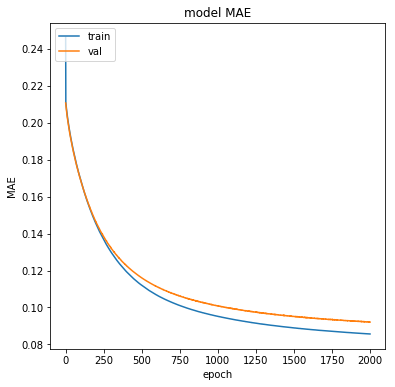

In [43]:
#plot history for MAE
fig_acc = plt.figure(figsize=(6, 6))
plt.plot(graph_plot.history['mean_absolute_error'])
plt.plot(graph_plot.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

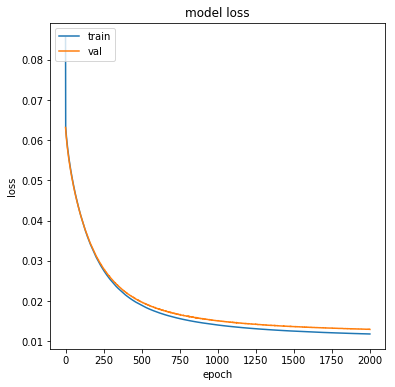

In [44]:
#plot history for loss
fig_acc = plt.figure(figsize=(6, 6))
plt.plot(graph_plot.history['loss'])
plt.plot(graph_plot.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

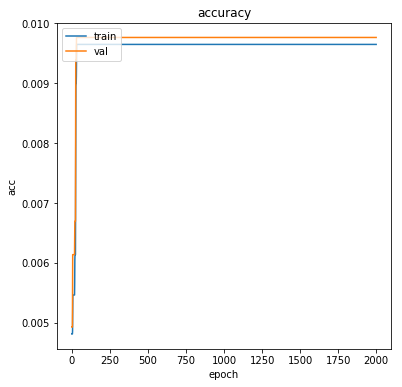

In [45]:
#plot history for accuracy
fig_acc = plt.figure(figsize=(6, 6))
plt.plot(graph_plot.history['acc'])
plt.plot(graph_plot.history['val_acc'])
plt.title('accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
score = model.predict(X_test)
print(score.min(), score.max())
score[:10]

0.006135207 0.8157626


array([[0.8157295 ],
       [0.8157295 ],
       [0.8157295 ],
       [0.8157295 ],
       [0.81574863],
       [0.8157295 ],
       [0.8157295 ],
       [0.8157295 ],
       [0.8157295 ],
       [0.8157295 ]], dtype=float32)

In [47]:
df_test_scal['score']=score
df_test_scal.head()

,unit_id,time_in_cycles,op_setting_1,op_setting_2,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_14,sensor_15,sensor_17,sensor_18,sensor_20,sensor_21,max,RUL_actual,RUL,score
0,1,1,0.238019,0.297150,0.597937,0.639243,0.691329,0.680395,0.617180,0.615094,...,0.670742,0.117564,0.694737,0.854123,0.625944,0.630724,0.684971,276,275,0.815729
1,1,2,0.476162,0.831354,0.626985,0.664861,0.647519,0.534663,0.507937,0.500000,...,0.514944,0.337173,0.642105,0.864693,0.484214,0.496301,0.684971,276,274,0.815729
2,1,3,0.833282,0.997625,0.060269,0.189055,0.312512,0.243225,0.146592,0.144025,...,0.514893,0.376695,0.315789,0.651163,0.164722,0.159476,0.684971,276,273,0.815729
3,1,4,0.999967,0.998812,0.000000,0.135525,0.286753,0.242061,0.000000,0.000000,...,0.550269,0.394807,0.305263,0.627907,0.005834,0.016866,0.684971,276,272,0.815729
4,1,5,0.595089,0.737886,0.238089,0.012028,0.022001,0.050986,0.293184,0.208805,...,0.036627,0.940070,0.021053,0.000000,0.141730,0.140123,0.684971,276,271,0.815749


In [48]:
#predicted number of cycles per unit in fraction
def cycles(data):
    return(data['time_in_cycles'] / (1-data['score']))
    
df_test_scal['maxpredcycles'] = cycles(df_test_scal)

def RUL_function(data):
    return(data['maxpredcycles'] - data['max'])

df_test_scal['RUL_pred'] = RUL_function(df_test_scal)
df_test_scal['RUL_pred'].head()

0     4.741833
1    10.168638
2    15.595443
3    21.022247
4    26.451869
Name: RUL_pred, dtype: float64

In [49]:
#RUL converted from fraction to number of cycles
t = df_test_scal.columns == 'RUL_pred'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(df_test_scal.unit_id.min(), df_test_scal.unit_id.max()+1):
    npredictedRUL=df_test_scal[df_test_scal.unit_id==i].iloc[df_test_scal[df_test_scal.unit_id==i].time_in_cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)
    
print("Number of values predicted:",len(predictedRUL))
opredictedRUL=np.asarray(predictedRUL)
opredictedRUL[:5]

Number of values predicted: 259


array([[269.78684836],
       [202.70921898],
       [212.19098799],
       [202.87599396],
       [206.82412545]])

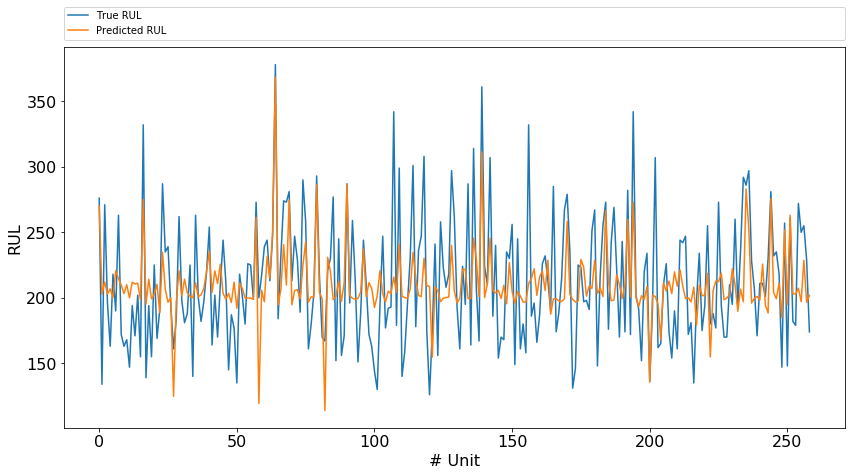

In [50]:
#Compare true and predicted RUL
plt.figure(figsize = (14, 7))
plt.plot(df_RUL['RUL_actual'])
plt.plot(predictedRUL)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.show()


In [51]:
#Show difference in the values predicted as a dataframe
xpredictedRUL = list(np.round(x) for x in opredictedRUL)
df1 = pd.concat([pd.Series(df_test_scal['RUL']), pd.Series(xpredictedRUL)], axis=1)
df1.columns = ['true', 'predicted']
df1['diff'] = df1['predicted']-df1['true']

In [52]:
df1.head()

,true,predicted,diff
0,275,[270.0],[-5.0]
1,274,[203.0],[-71.0]
2,273,[212.0],[-61.0]
3,272,[203.0],[-69.0]
4,271,[207.0],[-64.0]
